# iEEG Data

Analyze iEEG data.

On this dataset, we compare:
- The set of time series methods {...}
- specparam measures, fit with a knee across the broad range of XX

## Dataset Details

This notebook analyzes data from the openly available MNI dataset.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF, FOOOFGroup
from fooof.plts import plot_spectra
from fooof.analysis import get_band_peak_fg
from neurodsp.aperiodic import compute_irasa
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_26000/1522764783.py:6: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_pickle
from apm.io.data import load_ieeg_file, load_ieeg_all
from apm.run import run_measures
from apm.analysis import (compute_all_corrs, unpack_corrs,
                          compute_corrs_to_feature, compute_diffs_to_feature)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_all
from apm.plts.utils import make_axes
from apm.plts.settings import EXT, LABELS
from apm.data.measures import SPECPARAM_SETTINGS_KNEE
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Set Up Paths

In [4]:
# Define the data folder
data_path = Path('/Users/tom/Data/External/iEEG/MNI/Wakefulness_AllRegions/')

In [5]:
# Define load path
db = APMDB()
LOADPATH = db.data_path / 'ieeg'

In [6]:
# Check the set of results files available for this dataset
get_files(LOADPATH)

['ieeg_all_corrs.p', 'ieeg_results.p', 'ieeg_specparam.json']

## Settings

In [7]:
# Define data information
fs = 200

In [8]:
# Set max time to load
max_time = 30

In [9]:
# Add plot kwargs
dot_kwargs = {
    's' : 16,
    'alpha' : 0.4,
}

In [10]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = db.figs_path / '53_ieeg_data'

## Load Data

In [11]:
# Get the list of available files
files = get_files(data_path)

In [12]:
# Check the number of files
n_files = len(files)
print('Number of files: {}'.format(n_files))

Number of files: 38


In [13]:
# Load all data files
all_data = load_ieeg_all(files, data_path, max_time)

In [14]:
# Check data size
n_chs, n_times = all_data.shape
print('Number of channels: {}'.format(n_chs))

Number of channels: 1772


## Data Checks

In [15]:
# Set example file index
file_ind = 27

In [16]:
# Set example channel index
chi = 1

In [17]:
# Load an example file of iEEG data
times, data = load_ieeg_file(files[file_ind], data_path, max_time)

In [18]:
# Check data shape
n_chs, n_times = data.shape
n_chs, n_times

(123, 6000)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


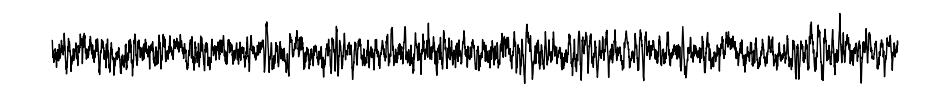

In [19]:
# Plot an example time series
plot_time_series(times, data[chi, :], lw=1., figsize=(12, 1))
plt.gca().axis('off');

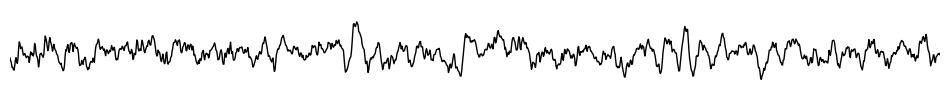

In [20]:
# Plot a zoomed in segment of a time series
plot_time_series(times, data[chi, :], xlim=[5, 12], lw=1., figsize=(12, 1))
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_timeseries' + EXT))

In [21]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[chi, :], fs, nperseg=2*fs, noverlap=fs)

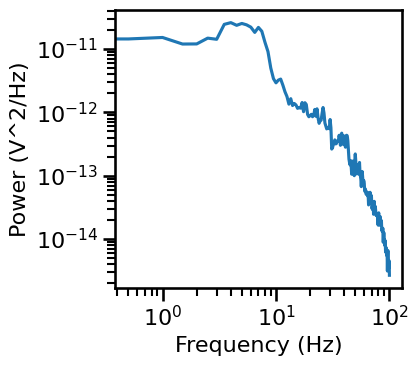

In [22]:
# Plot the power spectrum
plot_power_spectra(freqs, powers, figsize=(4.5, 4),
                   save_fig=SAVE_FIG, file_name='ieeg_psd' + EXT, file_path=FIGPATH)

### Check Spectral Fits

In [23]:
# Load specparam measures
fg = FOOOFGroup()
fg.load('ieeg_specparam', LOADPATH)

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 1479                            
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                               Power spectra were fit with a knee.                                
                                                                                                  
          

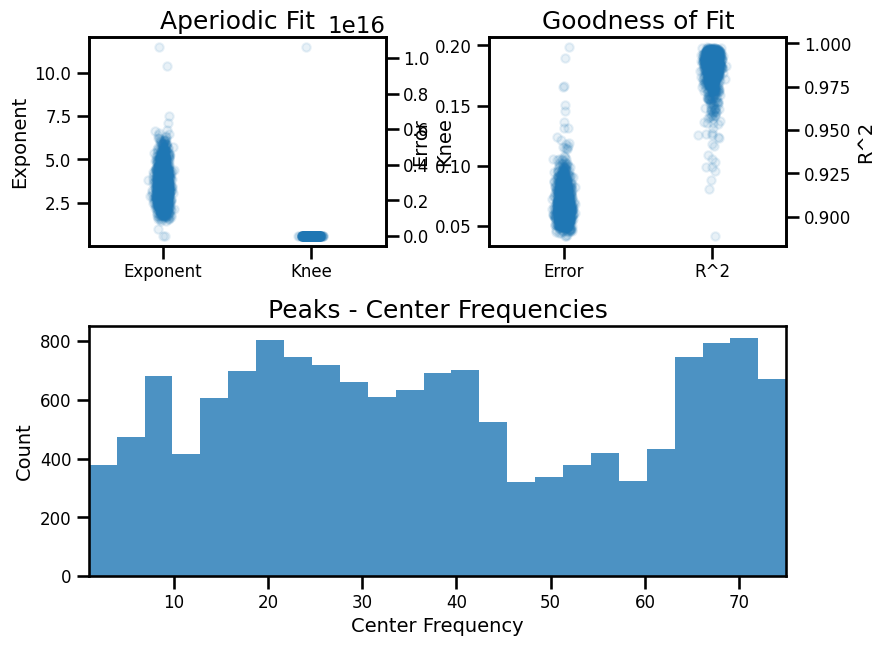

In [24]:
# Check overall group results
fg.print_results()
fg.plot()

## Example Spectral Model

In [25]:
fit_range = [1, 75]

In [26]:
# Fit a spectral model to example data
fm = FOOOF(**SPECPARAM_SETTINGS_KNEE)
fm.fit(freqs, powers, fit_range)

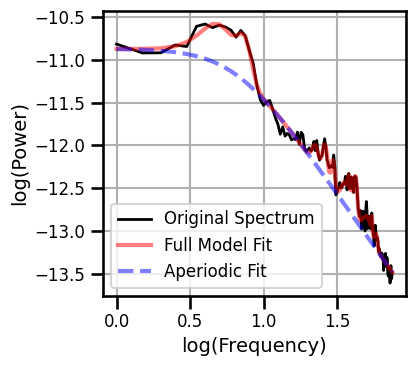

In [27]:
# Plot the specparam spectral model
fm.plot(plt_log=True, figsize=(4.5, 4),
        save_fig=SAVE_FIG, file_name='ieeg_spectral_model' + EXT, file_path=FIGPATH)

#### IRASA

In [28]:
# Compute the IRASA decomposition
freqs_ir, psd_ap, psd_pe = compute_irasa(data[chi, :], fs, fit_range)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/fooof/plts/spectra.py:77: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs) if log_freqs else freqs


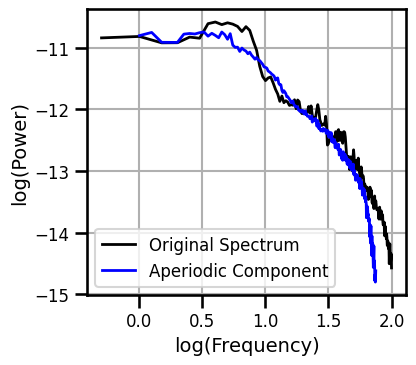

In [29]:
# Plot the IRASA data & aperiodic component
plot_spectra([freqs, freqs_ir], [powers, psd_ap], log_freqs=True, figsize=(4.5, 4),
             log_powers=True, colors=['black', 'blue'], labels=['Original Spectrum', 'Aperiodic Component'],
             save_fig=SAVE_FIG, file_name='ieeg_irasa_model' + EXT, file_path=FIGPATH)

## Load Results

In [30]:
# Load precomputed aperiodic measure results
results = load_pickle('ieeg_results', LOADPATH)

In [31]:
# Check size of computed results [n_chs]
results['dfa'].shape

(1479,)

### Add specparam results

In [32]:
# Define band range for peaks
band_range = [2, 25]

In [33]:
# Get peak powers
peak_powers = get_band_peak_fg(fg, band_range)[:, 1]

In [34]:
# Check number of nan values
print('# of nan: {}'.format(sum(np.isnan(peak_powers))))

# of nan: 18


In [35]:
# Replace nan values with zeros
peak_powers = np.nan_to_num(peak_powers)

### Check Measures & Labels

In [36]:
# Check list of computed measures
print(list(results.keys()))

['autocorr_decay_time', 'dfa', 'higuchi_fd', 'hjorth_complexity', 'lempelziv', 'sample_entropy', 'perm_entropy', 'irasa', 'specparam', 'specparam_knee', 'specparam_knee_freq']


In [37]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
knee_measures = ['specparam_knee', 'specparam_knee_freq']
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures];
[ts_measures.remove(meas) for meas in knee_measures];

In [38]:
# Collect labels for time series measures
ts_labels = [LABELS[meas] for meas in ts_measures]

### Compute Correlations

In [39]:
# Load precomputed aperiodic measure results
all_corrs = load_pickle('ieeg_all_corrs', LOADPATH)

In [40]:
# # Compute correlations across all pairs of methods
# all_corrs = compute_all_corrs(results)

#### Compare exponent measures

In [41]:
# Check exponent data ranges
print('SP: {:1.2f}-{:1.2f}'.format(np.min(results['specparam']), np.max(results['specparam'])))
print('IR: {:1.2f}-{:1.2f}'.format(np.min(results['irasa']), np.max(results['irasa'])))

SP: 0.58-11.50
IR: 2.60-13.34


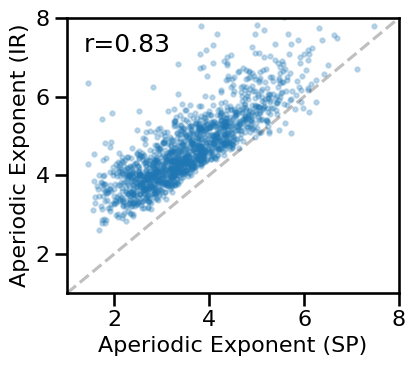

In [42]:
# Compare aperiodic exponent from specparam & IRASA
plot_dots(results['specparam'], results['irasa'], alpha=0.25, tposition='tl',
          xlim=[1, 8], ylim=[1, 8], expected=[1, 8], s=10, figsize=(4.5, 4),
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='ieeg_exp_exp' + EXT, file_path=FIGPATH)

In [43]:
# Check correlation between exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.831  CI[+0.808, +0.852],  p=0.000


In [44]:
# Compute average difference between exponent estimates
exp_diffs = np.abs(results['specparam'] - results['irasa'])

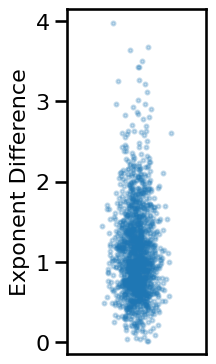

In [45]:
# Plot the distribution of differences between exponent measures
plot_dots(np.random.randn(len(exp_diffs)) * 0.15, exp_diffs, add_corr=False, figsize=(2.5, 4),
          xticks=[], xlim=[-1, 1], ylim=[-0.15, 4.15], ylabel='Exponent Difference', alpha=0.25, s=8,
          save_fig=SAVE_FIG, file_name='ieeg_exp_diffs' + EXT, file_path=FIGPATH)

In [46]:
# Check median and range of exponent differences
print('Median exp diff: \t{:1.2f}'.format(np.median(exp_diffs)))
print('Min/Max: \t\t{:1.2f}, {:1.2f}'.format(np.min(exp_diffs), np.max(exp_diffs)))

Median exp diff: 	1.03
Min/Max: 		0.01, 12.75


#### Compare exponent to other measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


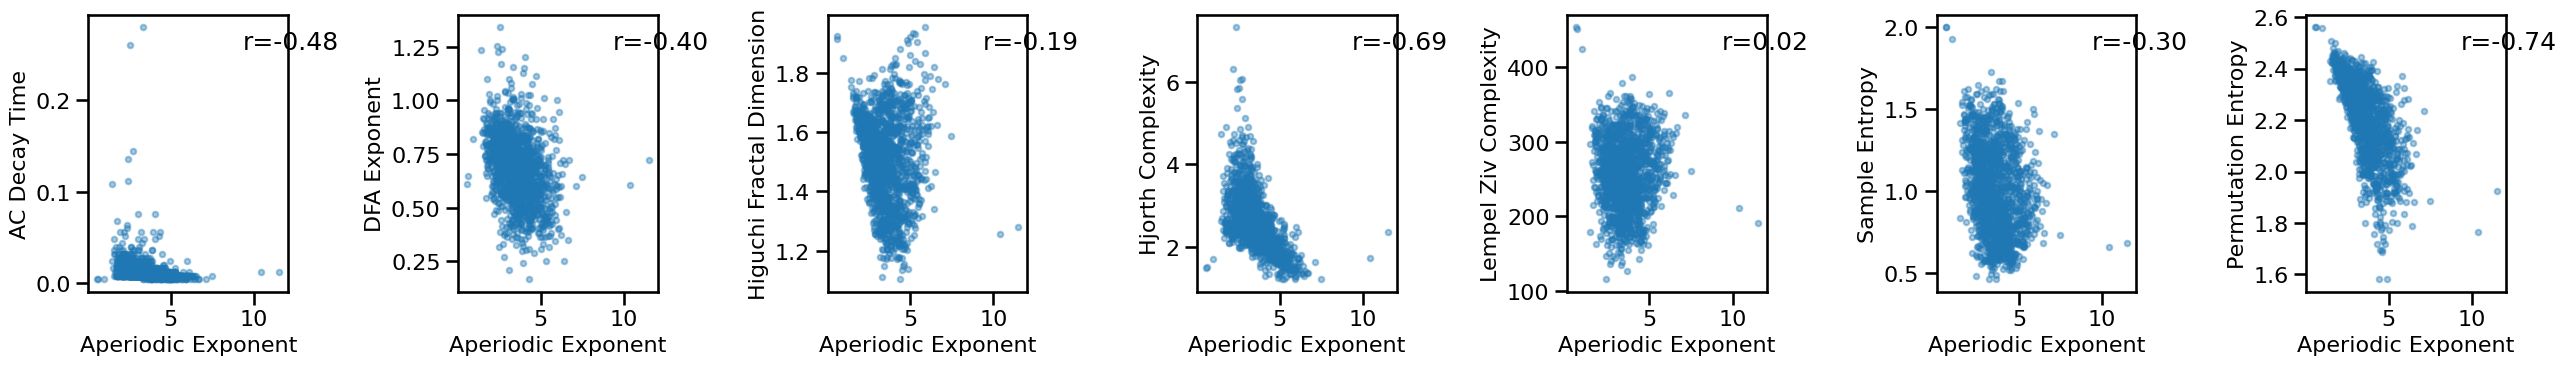

In [47]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.4)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_exp_ts_scatters' + EXT))

In [48]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa'][meas]))

autocorr_decay_time
    SP-EXP:   r=-0.482  CI[-0.522, -0.439],  p=0.000
    IR-EXP:   r=-0.651  CI[-0.683, -0.616],  p=0.000
dfa
    SP-EXP:   r=-0.400  CI[-0.444, -0.355],  p=0.000
    IR-EXP:   r=-0.228  CI[-0.277, -0.181],  p=0.000
higuchi_fd
    SP-EXP:   r=-0.185  CI[-0.237, -0.133],  p=0.000
    IR-EXP:   r=+0.198  CI[+0.148, +0.247],  p=0.000
hjorth_complexity
    SP-EXP:   r=-0.687  CI[-0.716, -0.655],  p=0.000
    IR-EXP:   r=-0.858  CI[-0.875, -0.839],  p=0.000
lempelziv
    SP-EXP:   r=+0.023  CI[-0.026, +0.072],  p=0.370
    IR-EXP:   r=+0.373  CI[+0.327, +0.417],  p=0.000
sample_entropy
    SP-EXP:   r=-0.301  CI[-0.345, -0.256],  p=0.000
    IR-EXP:   r=+0.050  CI[-0.000, +0.100],  p=0.056
perm_entropy
    SP-EXP:   r=-0.742  CI[-0.765, -0.716],  p=0.000
    IR-EXP:   r=-0.444  CI[-0.485, -0.401],  p=0.000


### Compare knee to other measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


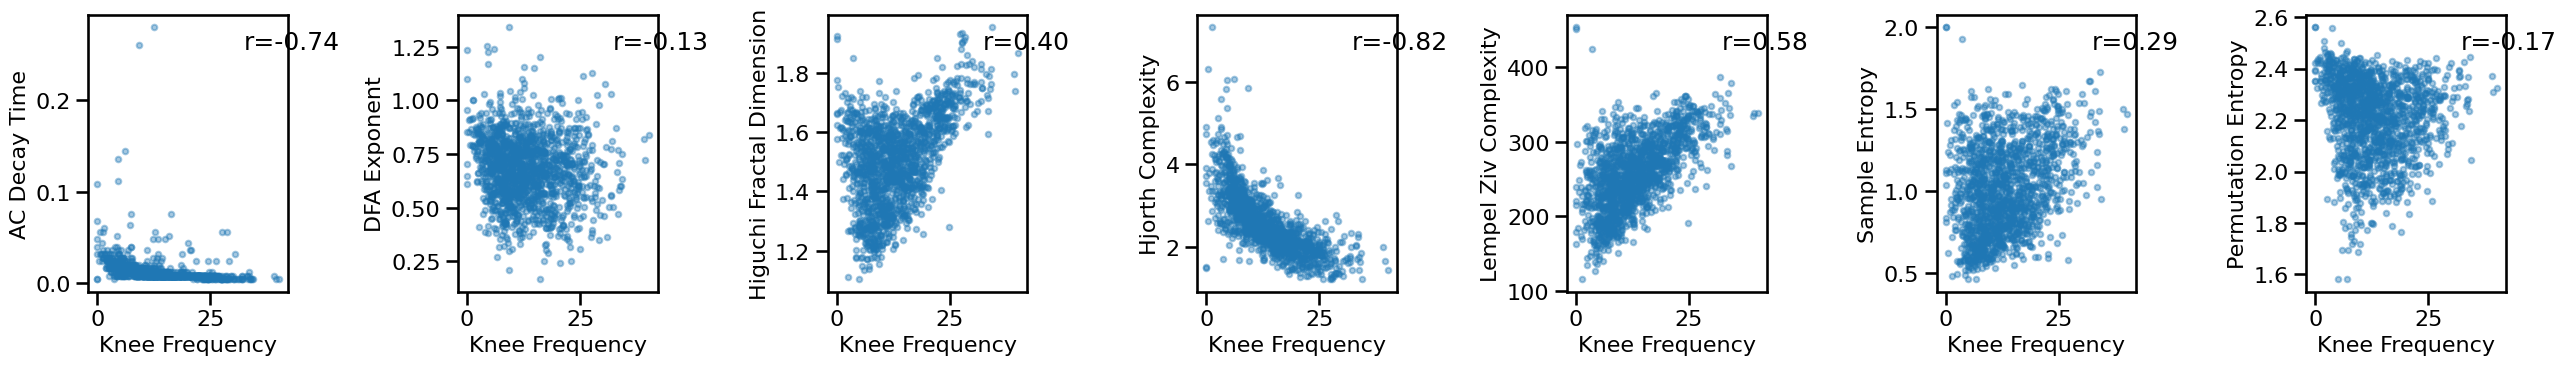

In [49]:
# Plot comparisons between knee and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.4)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam_knee_freq'], results[meas], **dot_kwargs,
              xlabel='Knee Frequency', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_knee_ts_scatters' + EXT))

In [50]:
# Check the correlations between time series and knee measures
for meas in ts_measures:
    print(meas)
    print('    KNEE:  \t', format_corr(*all_corrs['specparam_knee'][meas]))
    print('    KNEE-FREQ: \t', format_corr(*all_corrs['specparam_knee_freq'][meas]))


autocorr_decay_time
    KNEE:  	 r=-0.648  CI[-0.682, -0.610],  p=0.000
    KNEE-FREQ: 	 r=-0.741  CI[-0.773, -0.707],  p=0.000
dfa
    KNEE:  	 r=-0.294  CI[-0.341, -0.246],  p=0.000
    KNEE-FREQ: 	 r=-0.134  CI[-0.185, -0.083],  p=0.000
higuchi_fd
    KNEE:  	 r=+0.092  CI[+0.039, +0.146],  p=0.000
    KNEE-FREQ: 	 r=+0.404  CI[+0.353, +0.454],  p=0.000
hjorth_complexity
    KNEE:  	 r=-0.816  CI[-0.838, -0.792],  p=0.000
    KNEE-FREQ: 	 r=-0.824  CI[-0.844, -0.801],  p=0.000
lempelziv
    KNEE:  	 r=+0.302  CI[+0.255, +0.349],  p=0.000
    KNEE-FREQ: 	 r=+0.583  CI[+0.542, +0.621],  p=0.000
sample_entropy
    KNEE:  	 r=-0.028  CI[-0.077, +0.021],  p=0.275
    KNEE-FREQ: 	 r=+0.292  CI[+0.243, +0.341],  p=0.000
perm_entropy
    KNEE:  	 r=-0.515  CI[-0.553, -0.474],  p=0.000
    KNEE-FREQ: 	 r=-0.172  CI[-0.222, -0.120],  p=0.000


### Compare Time Series Measures to Each Other

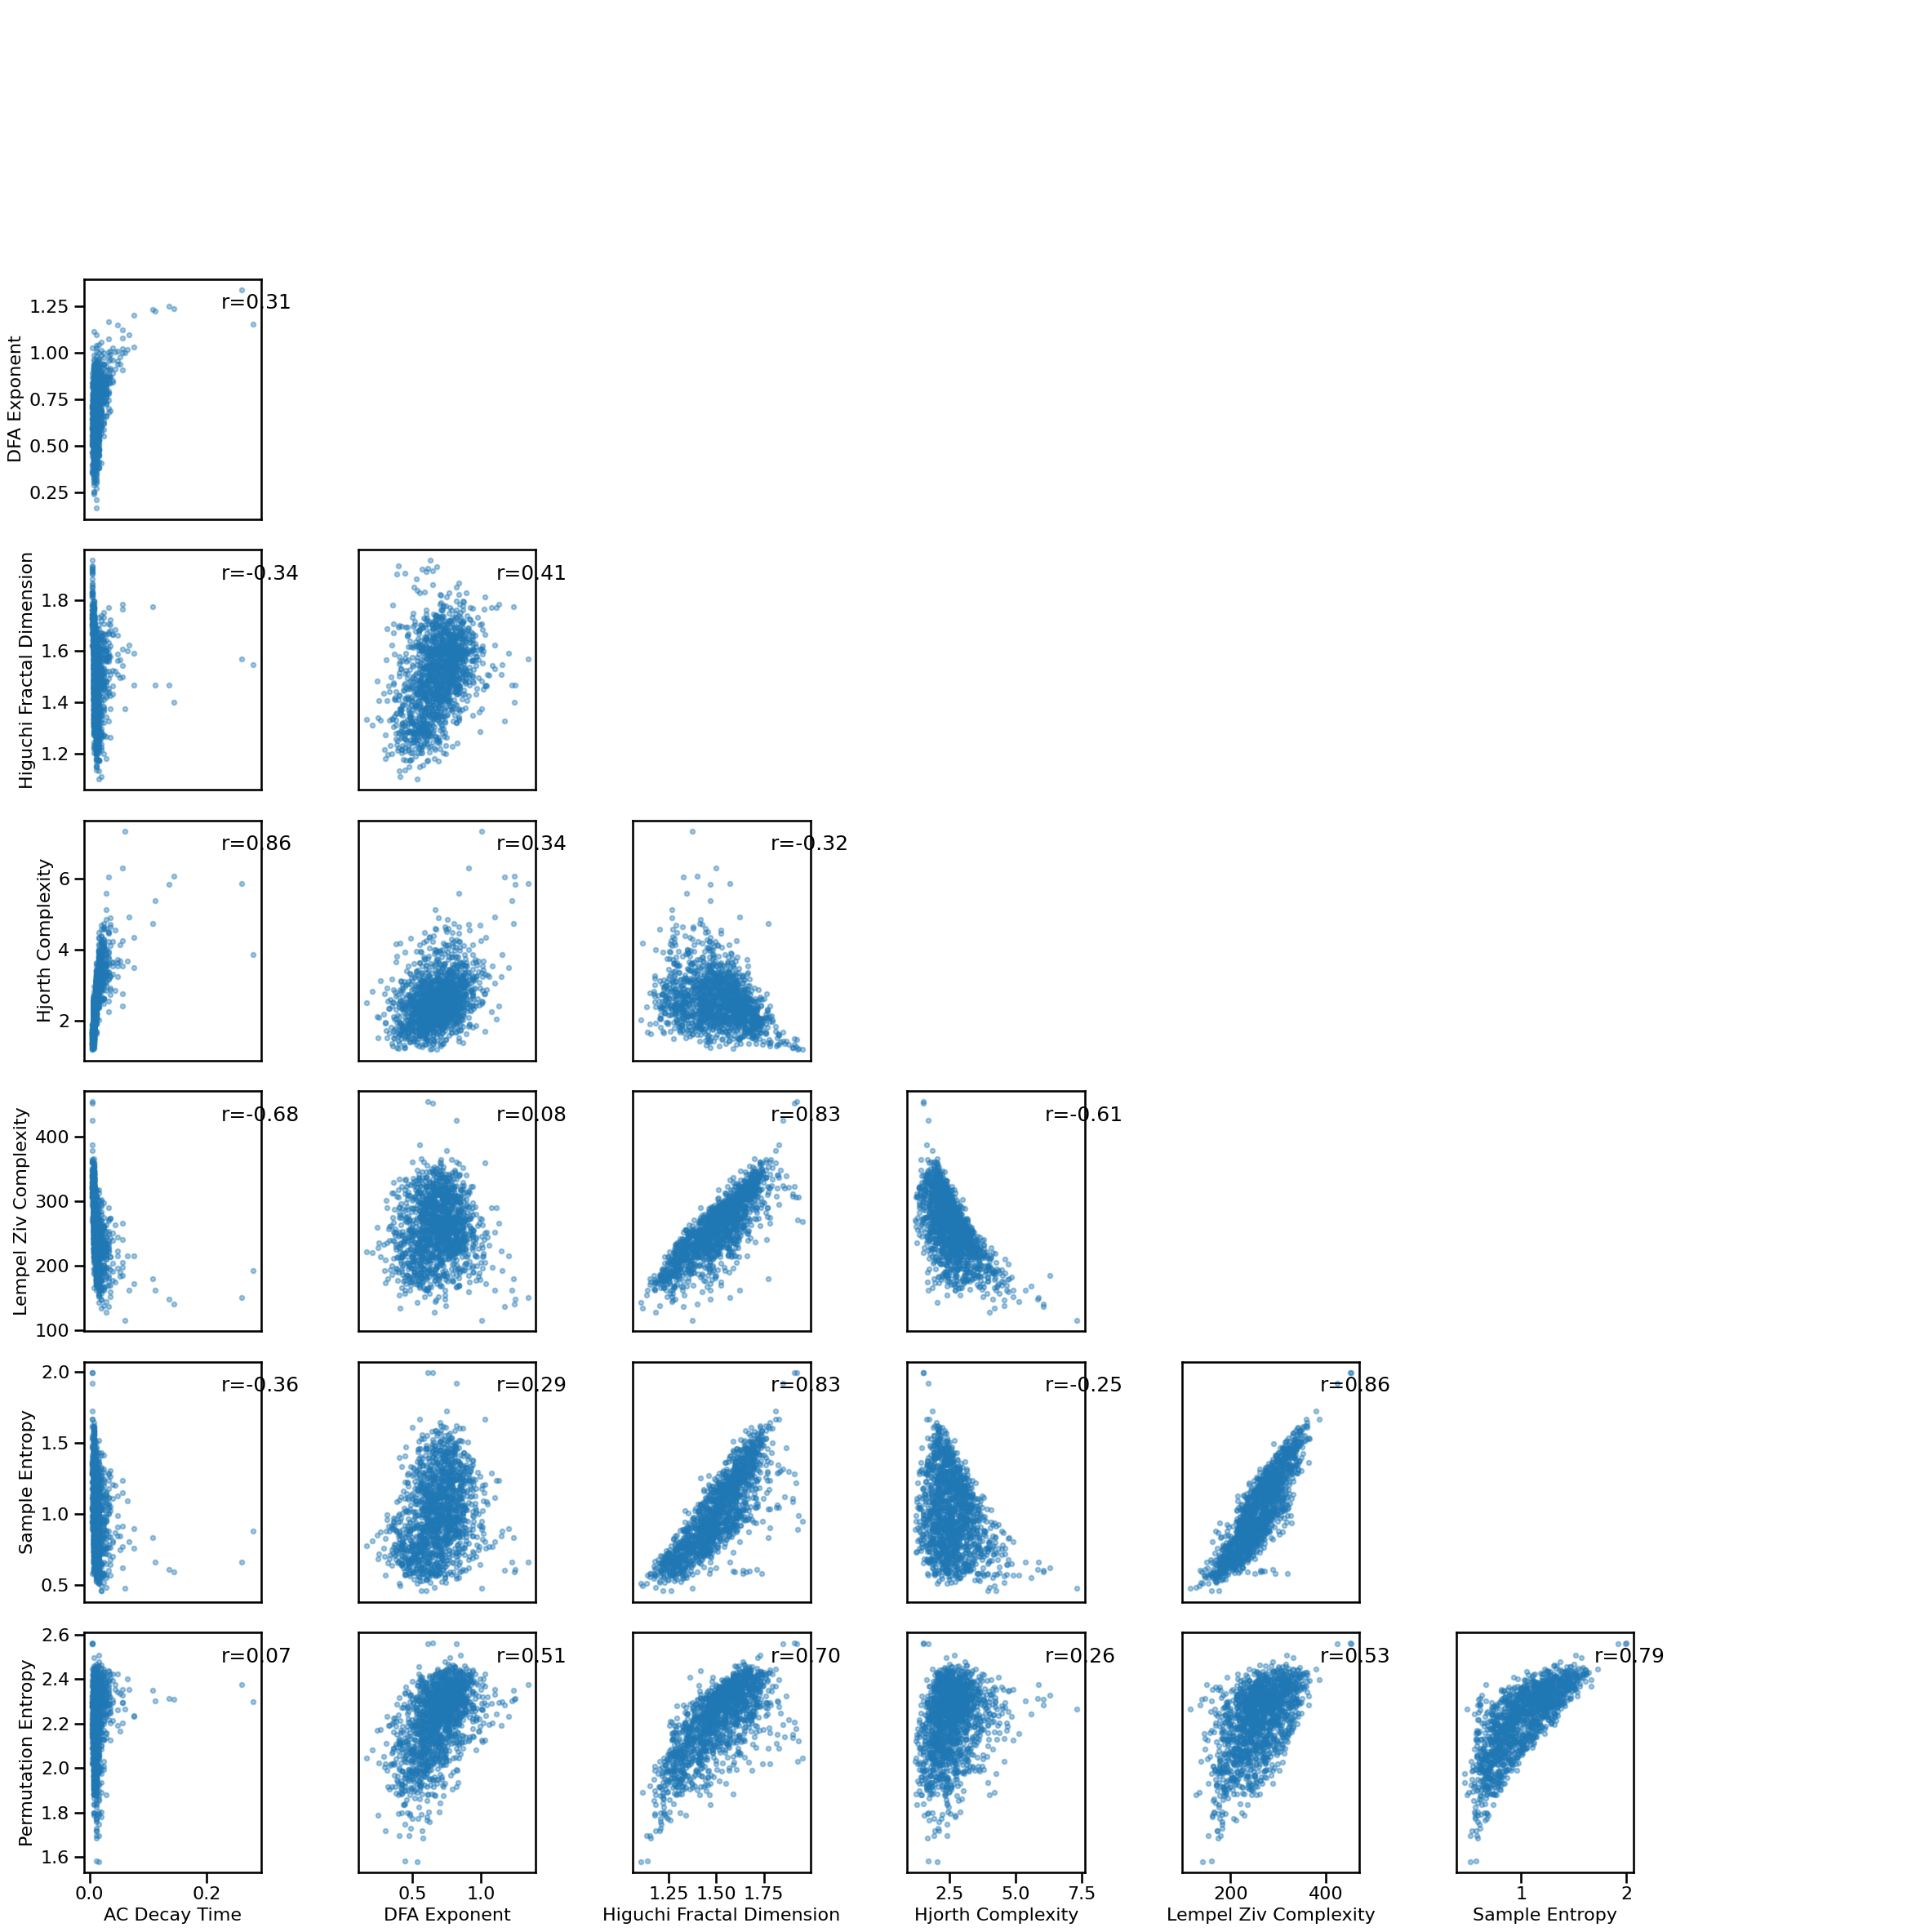

In [51]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures, **dot_kwargs)

### Correlations

In [52]:
# Subselect time domain measures
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures and ke not in knee_measures}

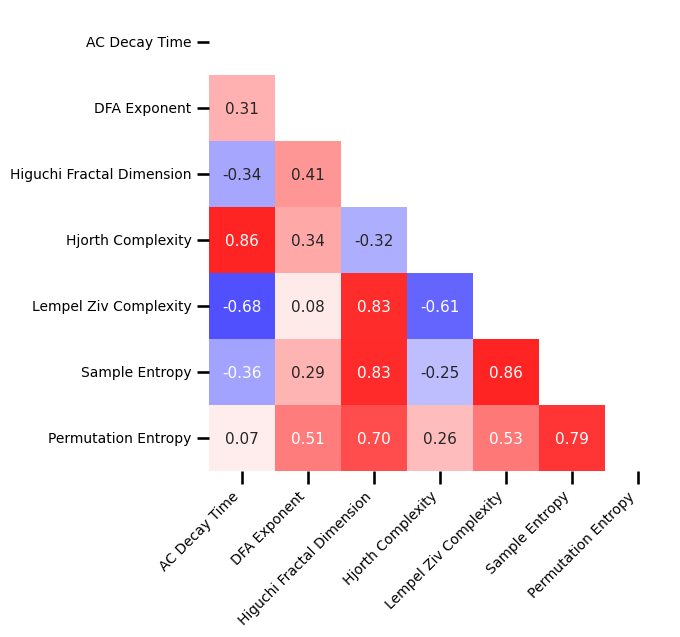

In [53]:
# Plot the correlations matrix across all time series measures
plot_corr_matrix(unpack_corrs(all_corrs_ts), cbar=False, figsize=(6, 6),
                 xticklabels=ts_labels, yticklabels=ts_labels,
                 save_fig=SAVE_FIG, file_name='ieeg_ts_corr_mat' + EXT, file_path=FIGPATH)

#### Exponent Correlations

In [54]:
# Extract the correlations between specparam and time domain measures
exp_corrs = np.atleast_2d([all_corrs['specparam'][label][0] for label in ts_measures]).T

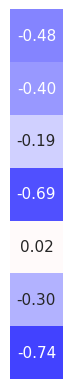

In [55]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs, cbar=False,
                 save_fig=SAVE_FIG, file_name='ieeg_exp_corrs' + EXT, file_path=FIGPATH)

#### Knee Correlations

In [56]:
# Extract the correlations between knee and time domain measures
knee_corrs = np.atleast_2d([all_corrs['specparam_knee_freq'][label][0] for label in ts_measures]).T

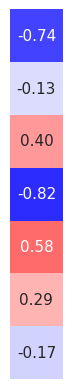

In [57]:
# Plot correlations between knee and time domain measures
plot_corr_matrix(knee_corrs, cbar=False,
                 save_fig=SAVE_FIG, file_name='ieeg_knee_corrs' + EXT, file_path=FIGPATH)

## Compare to Peaks

In [58]:
# Compute correlations between aperiodic measures and peak powers
peak_corrs = compute_corrs_to_feature(results, peak_powers)

In [59]:
# # Compute differences between correlations between aperiodic measures and peak powers
# peak_corr_diffs = compute_diffs_to_feature(results, peak_powers)

In [60]:
# Check the correlations between peak powers and aperiodic measures
print('Correlations with peak powers:')
for label in peak_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*peak_corrs[label]))

Correlations with peak powers:
     autocorr_decay_time :   r=-0.282  CI[-0.331, -0.233],  p=0.000
     dfa                 :   r=-0.395  CI[-0.438, -0.351],  p=0.000
     higuchi_fd          :   r=-0.280  CI[-0.329, -0.230],  p=0.000
     hjorth_complexity   :   r=-0.376  CI[-0.418, -0.330],  p=0.000
     lempelziv           :   r=-0.096  CI[-0.146, -0.047],  p=0.000
     sample_entropy      :   r=-0.289  CI[-0.336, -0.240],  p=0.000
     perm_entropy        :   r=-0.492  CI[-0.533, -0.452],  p=0.000
     irasa               :   r=+0.374  CI[+0.330, +0.417],  p=0.000
     specparam           :   r=+0.449  CI[+0.408, +0.488],  p=0.000
     specparam_knee      :   r=+0.405  CI[+0.361, +0.447],  p=0.000
     specparam_knee_freq :   r=+0.308  CI[+0.261, +0.353],  p=0.000


In [61]:
# Organize correlations between peak powers and time domain measures
peak_corrs_ts = np.atleast_2d([peak_corrs[label][0] for label in ts_measures]).T

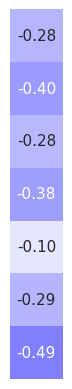

In [62]:
# Plot correlations between peak powers and time domain measures
plot_corr_matrix(peak_corrs_ts, cbar=False,
                 save_fig=SAVE_FIG, file_name='ieeg_peak_corrs' + EXT, file_path=FIGPATH)

## Conclusions

The iEEG data broadly replicates analyses on the EEG datasets. 